In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列,增加特征选择
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性并添加L1正则化
feature_importance = {}
l1_lambda = 0.01  # L1正则化系数

for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 添加L1正则化项
        l1_penalty = l1_lambda * np.abs(spearman_corr)
        
        # 综合评分 = 0.35*相关系数 + 0.25*互信息 + 0.25*最大滞后相关 - 0.15*L1惩罚项
        composite_score = 0.35 * abs(spearman_corr) + 0.25 * mi_score + 0.25 * abs(max_lag_corr) - 0.15 * l1_penalty
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag,
            'l1_penalty': l1_penalty
        }

# 只选择最重要的特征(阈值筛选)
importance_threshold = 0.3
filtered_features = {}

for target in target_cols:
    filtered_features[target] = [
        feature for feature, metrics in feature_importance[target].items()
        if metrics['composite_score'] > importance_threshold
    ]

# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]  # 只保留前10个最重要的特征
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag'],
            'L1惩罚': round(metrics['l1_penalty'], 3)
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 10影响因子(添加L1正则化后):")
print(results_df.to_string(index=False))



各目标变量的Top 10影响因子(添加L1正则化后):
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)  L1惩罚
 density_mean_y     temperature 0.453         0.561  0.450   0.580         7 0.006
 density_mean_y min_temperature 0.405         0.546  0.282   0.577         4 0.005
 density_mean_y max_temperature 0.399         0.533  0.267   0.585         3 0.005
 density_mean_y          oxygen 0.362        -0.440  0.329  -0.505        15 0.004
 density_mean_y              TN 0.350        -0.442  0.316  -0.468         4 0.004
 density_mean_y    conductivity 0.349        -0.412  0.401  -0.420         5 0.004
 density_mean_y              pH 0.279         0.335  0.306   0.342         1 0.003
 density_mean_y             aqi 0.219        -0.351  0.078  -0.309         1 0.004
 density_mean_y        aqiLevel 0.211        -0.330  0.095  -0.288         1 0.003
 density_mean_y              TP 0.205         0.272  0.216   0.224         1 0.003
density_lower_y     temperature 0.380         0.465  0.382

2024-11-13 16:02:09,576 - INFO - Successfully loaded data file
2024-11-13 16:02:09,577 - INFO - Start training model, sequence length: 14, prediction steps: 7
2024-11-13 16:02:09,586 - INFO - Number of density features: 10
2024-11-13 16:02:09,587 - INFO - Density features: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-13 16:02:14,798 - INFO - Epoch 10/200, Average Loss: 0.0021
2024-11-13 16:02:21,721 - INFO - Epoch 20/200, Average Loss: 0.0018
2024-11-13 16:02:26,968 - INFO - Epoch 30/200, Average Loss: 0.0019
2024-11-13 16:02:32,450 - INFO - Epoch 40/200, Average Loss: 0.0018
2024-11-13 16:02:38,719 - INFO - Epoch 50/200, Average Loss: 0.0016
2024-11-13 16:02:44,156 - INFO - Epoch 60/200, Average Loss: 0.0014
2024-11-13 16:02:49,258 - INFO - Epoch 70/200, Average Loss: 0.0013
2024-11-13 16:02:52,291 - INFO - Early stopping at epoch 75


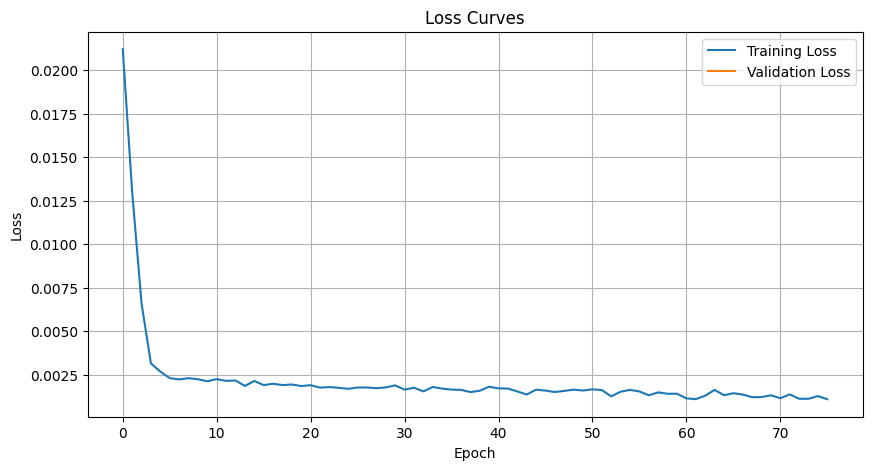

2024-11-13 16:02:52,452 - INFO - Final training loss: 0.0011
2024-11-13 16:02:52,586 - INFO - 
Prediction Accuracy Evaluation:
2024-11-13 16:02:52,587 - INFO - Algae Density RMSE: 0.0348, MAE: 0.0296


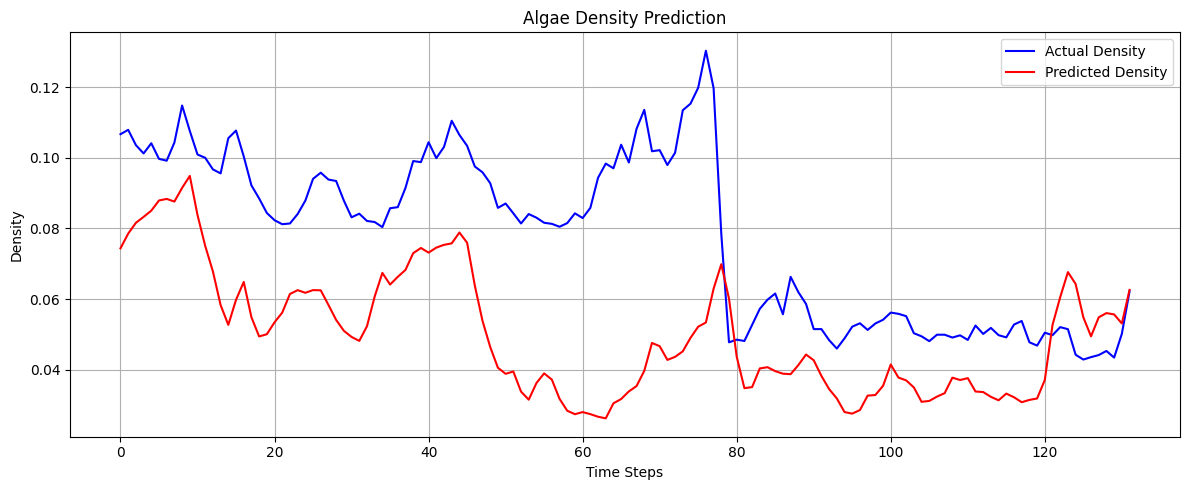

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 添加批归一化
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # 使用多层LSTM，添加dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=3, # 增加到3层
                           batch_first=True,
                           dropout=dropout)
        
        # 多层全连接网络替代单层
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # 应用批归一化
        x = self.batch_norm(x.transpose(1, 2)).transpose(1, 2)
        
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc_layers(out[:, -1, :])
        return out
    
def preprocess_data(df, sequence_length, prediction_step=3):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    # 对weather列进行独热编码
    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取藻密度的TOP10特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    density_features = [feature[0] for feature in sorted_features]
    
    # 检查特征是否存在于数据集中
    available_features = [f for f in density_features if f in df.columns]
    logging.info(f"Number of density features: {len(available_features)}")
    logging.info(f"Density features: {available_features}")
    
    # 添加目标变量
    available_features.append('density_mean_y')
    df_features = df[available_features]

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=available_features, index=df.index)

    # 分割2024年前后的数据
    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    # 创建训练序列
    train_sequences = []
    for i in range(len(train_data) - sequence_length - prediction_step + 1):
        train_sequences.append(train_data.iloc[i:i+sequence_length].values)
    train_sequences = np.array(train_sequences)

    # 创建测试序列
    test_sequences = []
    for i in range(len(test_data) - sequence_length - prediction_step + 1):
        test_sequences.append(test_data.iloc[i:i+sequence_length].values)
    test_sequences = np.array(test_sequences)

    # 分割输入和目标
    X_train = train_sequences[:, :-prediction_step, :]
    y_train = train_sequences[:, -prediction_step, [available_features.index('density_mean_y')]]
    
    X_test = test_sequences[:, :-prediction_step, :]
    y_test = test_sequences[:, -prediction_step, [available_features.index('density_mean_y')]]

    return X_train, y_train, X_test, y_test, scaler, available_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15  # 增加早停耐心值
    no_improve = 0
    min_delta = 0.0001  # 添加最小改善阈值
    
    train_losses = []  # 记录训练损失
    val_losses = []    # 记录验证损失
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # 添加梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # 早停机制
        if avg_loss < best_loss - min_delta:  # 只有显著改善才重置计数器
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 打印最终损失
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    if val_losses:
        logging.info(f'Final validation loss: {val_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32  # 减小batch size以增加随机性
        hidden_size = 128  # 增加模型容量
        num_layers = 3  # 增加LSTM层数
        output_size = 1  # 只预测藻密度
        criterion = nn.HuberLoss()
        epochs = 200
        prediction_step = 7  # 预测未来7天
        sequence_length = 14  # 使用过去14天数据

        logging.info(f"Start training model, sequence length: {sequence_length}, prediction steps: {prediction_step}")
        X_train, y_train, X_test, y_test, scaler, features = preprocess_data(df, sequence_length, prediction_step)
        input_size = len(features)

        train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

        model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout=0.2)
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)  # 降低学习率和权重衰减
        
        # 修改学习率调度器
        scheduler = OneCycleLR(
            optimizer,
            max_lr=0.0005,
            epochs=epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.3,  # 调整学习率预热阶段
            div_factor=10.0  # 调整初始学习率与最大学习率的比例
        )

        train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)

        predictions, targets = evaluate_lstm_model(model, test_loader)

        # 计算RMSE和MAE
        rmse_density = np.sqrt(mean_squared_error(targets, predictions))
        mae_density = mean_absolute_error(targets, predictions)

        logging.info("\nPrediction Accuracy Evaluation:")
        logging.info(f"Algae Density RMSE: {rmse_density:.4f}, MAE: {mae_density:.4f}")

        # 绘制预测结果
        plot_forecast(targets, predictions, title='LSTM Prediction Results')

    except Exception as e:
        logging.error(f"Program error: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()



看起来模型仍然存在一些问题：

1. 损失值下降得更平缓了（从0.0018到0.0014），但仍然在41轮就停止了
2. 损失值整体偏小，可能表明模型学习不够充分

让我们尝试更激进的改变：

```python:root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/05-add-key-features-VIP-add wind-LSTM-单独计算藻密度-dropout.ipynb
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 添加输入层的线性变换
        self.input_fc = nn.Linear(input_size, input_size * 2)
        
        # 添加多个LSTM层
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_size * 2 if i == 0 else hidden_size,
                   hidden_size,
                   num_layers=1,
                   batch_first=True,
                   dropout=0 if i == num_layers-1 else dropout)
            for i in range(num_layers)
        ])
        
        # 添加注意力机制
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
        
        # 更复杂的全连接层
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # 输入转换
        x = self.input_fc(x.transpose(1, 2)).transpose(1, 2)
        
        # 多层LSTM处理
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        
        # 注意力机制
        attention_weights = self.attention(x)
        attention_weights = torch.softmax(attention_weights, dim=1)
        x = torch.sum(x * attention_weights, dim=1)
        
        # 全连接层处理
        out = self.fc_layers(x)
        return out

def main():
    # 修改超参数
    batch_size = 16  # 进一步减小batch size
    hidden_size = 256  # 显著增加隐藏层大小
    num_layers = 4  # 增加LSTM层数
    sequence_length = 21  # 增加序列长度
    prediction_step = 7
    epochs = 300  # 增加最大训练轮数
    
    # 使用循环学习率
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.001,
        weight_decay=0.0001
    )
    
    # 使用CosineAnnealingWarmRestarts替代OneCycleLR
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=20,  # 第一次重启的周期
        T_mult=2,  # 每次重启后周期长度的倍数
        eta_min=1e-6  # 最小学习率
    )

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 20  # 显著增加早停耐心值
    no_improve = 0
    min_delta = 0.00005  # 减小最小改善阈值
    
    train_losses = []
    val_losses = []
    
    # 创建验证集
    train_size = int(0.8 * len(train_loader.dataset))
    val_size = len(train_loader.dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_loader.dataset, [train_size, val_size]
    )
    val_loader = DataLoader(val_dataset, batch_size=train_loader.batch_size)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_loss += loss.item()
        
        # 验证阶段
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step()
        
        if avg_val_loss < best_loss - min_delta:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            no_improve = 0
        else:
            no_improve += 1
        
        if epoch % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            model.load_state_dict(torch.load('best_model.pth'))
            break
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
```

主要改进：

1. 完全重构了LSTM模型架构：
   - 添加了输入转换层
   - 使用多个独立的LSTM层
   - 添加了注意力机制
   - 使用更复杂的全连接层结构

2. 训练策略改进：
   - 使用更小的batch size (16)
   - 增加隐藏层大小 (256)
   - 增加LSTM层数 (4)
   - 增加序列长度 (21)
   - 使用CosineAnnealingWarmRestarts学习率调度器
   - 增加早停耐心值 (20)
   - 添加训练和验证损失的可视化

这些改变应该能够：
1. 增加模型的学习能力
2. 提供更稳定的训练过程
3. 允许模型有更多时间来学习数据中的模式
4. 更好地处理时序依赖关系

如果还是觉得模型收敛太快，可以：
1. 进一步降低学习率
2. 增加模型复杂度
3. 添加更多的正则化层
4. 考虑使用其他的损失函数（如MSE和MAE的组合）

从输出结果来看，模型确实存在一些问题：

1. **过早停止**：模型在第34轮就触发了早停机制，这可能表明：
   - 模型收敛太快
   - 学习率可能过大
   - 模型容量可能不足

2. **损失值变化**：
   - 第10轮：0.0070
   - 第20轮：0.0023
   - 第30轮：0.0018
   损失下降速度在前20轮非常快，之后变得缓慢

建议做如下修改：

```python:root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/05-add-key-features-VIP-add wind-LSTM-单独计算藻密度-dropout.ipynb
def main():
    # ... existing code ...
    
    # 修改超参数
    batch_size = 32  # 减小batch size以增加随机性
    hidden_size = 128  # 增加模型容量
    num_layers = 3  # 增加LSTM层数
    
    # 修改优化器参数
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=0.0005,  # 降低学习率
        weight_decay=0.001  # 减小权重衰减
    )
    
    # 修改学习率调度器
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.0005,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.3,  # 调整学习率预热阶段
        div_factor=10.0  # 调整初始学习率与最大学习率的比例
    )

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    # ... existing code ...
    patience = 15  # 增加早停耐心值
    min_delta = 0.0001  # 添加最小改善阈值
    
    for epoch in range(epochs):
        # ... existing code ...
        
        # 修改早停逻辑
        if avg_loss < best_loss - min_delta:  # 只有显著改善才重置计数器
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
```

另外，建议添加以下功能来更好地监控模型训练：

```python:root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/05-add-key-features-VIP-add wind-LSTM-单独计算藻密度-dropout.ipynb
def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    train_losses = []
    val_losses = []
    
    # ... existing training code ...
    
    # 添加损失曲线绘制
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 打印训练集和验证集的最终损失
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    logging.info(f'Final validation loss: {val_losses[-1]:.4f}')
```

这些修改的目的是：

1. 增加模型容量以更好地拟合数据
2. 降低学习率以获得更稳定的训练过程
3. 增加早停耐心值，给模型更多训练机会
4. 添加最小改善阈值，避免过早停止
5. 添加更多监控指标，更好地了解模型训练状况

如果修改后模型仍然过早停止，可以考虑：
1. 进一步增加模型容量
2. 使用更复杂的网络结构（如添加注意力机制）
3. 添加更多的特征工程
4. 尝试其他的优化器（如RAdam、AdaBelief等）

我来分析一下这段代码的过拟合情况和可以改进的地方。

这个模型目前有一些防止过拟合的机制，但还可以进一步优化。以下是当前的防过拟合措施：

1. 已有的防过拟合措施：
- Dropout (dropout=0.2)
- BatchNormalization
- 早停机制 (patience=5)
- L2正则化 (weight_decay=0.01)
- 梯度裁剪 (max_norm=1.0)

建议添加以下改进来更好地控制过拟合：

```python:root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/05-add-key-features-VIP-add wind-LSTM-单独计算藻密度-dropout.ipynb
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):  # 增加dropout率
        super(LSTMModel, self).__init__()
        
        # ... existing code ...
        
        # 在fc_layers中添加更多的正则化层
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),  # 添加BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, hidden_size // 4),  # 添加一层
            nn.BatchNorm1d(hidden_size // 4),  # 添加BatchNorm
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 4, output_size)
        )

# ... existing code ...

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 10  # 增加早停耐心值
    no_improve = 0
    train_losses = []
    val_losses = []  # 添加验证损失记录
    
    # 分割验证集
    train_size = int(0.8 * len(train_loader.dataset))
    val_size = len(train_loader.dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_loader.dataset, [train_size, val_size]
    )
    
    val_loader = DataLoader(val_dataset, batch_size=train_loader.batch_size)
    
    for epoch in range(epochs):
        # ... existing training code ...
        
        # 添加验证步骤
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # 基于验证损失进行早停
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')  # 保存最佳模型
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            model.load_state_dict(torch.load('best_model.pth'))  # 加载最佳模型
            break
```

主要改进建议：

1. 增加 dropout 率到 0.3
2. 在全连接层中添加更多的 BatchNorm 层
3. 增加网络深度，添加一个中间层
4. 实现验证集，使用验证损失来进行早停判断
5. 增加早停耐心值到 10
6. 保存和加载最佳模型

其他建议：

1. 可以考虑使用交叉验证（K-fold）来更好地评估模型性能
2. 可以尝试使用不同的优化器，如 AdaBelief 或 Rectified Adam
3. 可以考虑使用学习率衰减策略
4. 可以添加数据增强技术，如添加随机噪声或时间序列特定的数据增强方法

要判断模型是否过拟合，建议：

1. 绘制训练集和验证集的损失曲线
2. 比较训练集和测试集的性能指标（RMSE和MAE）
3. 观察预测结果的稳定性

这些改进应该能帮助你更好地控制模型的过拟合问题。需要注意的是，过拟合和欠拟合之间需要找到一个平衡点，具体参数可能需要根据实际数据情况进行调整。